In [3]:
import pandas as pd
train_df = pd.read_csv('../data/cleaned_train.csv')
tdf = pd.read_csv('../data/clean_test.csv')

In [4]:
!pip install statsmodels


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
train_df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,clean_prompt,clean_response_a,clean_response_b
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,is it morally right to try to have a certain p...,the question of whether it is morally right to...,"as an ai, i don't have personal beliefs or opi..."
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,what is the difference between marriage licens...,a marriage license is a legal document that al...,a marriage license and a marriage certificate ...
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,explain function calling. how would you call a...,function calling is the process of invoking or...,function calling is the process of invoking a ...
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0,how can i create a test set for a very rare ca...,creating a test set for a very rare category c...,when building a classifier for a very rare cat...
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0,what is the best way to travel from tel-aviv t...,the best way to travel from tel aviv to jerusa...,the best way to travel from tel-aviv to jerusa...


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57477 entries, 0 to 57476
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                57477 non-null  int64 
 1   model_a           57477 non-null  object
 2   model_b           57477 non-null  object
 3   prompt            57477 non-null  object
 4   response_a        57477 non-null  object
 5   response_b        57477 non-null  object
 6   winner_model_a    57477 non-null  int64 
 7   winner_model_b    57477 non-null  int64 
 8   winner_tie        57477 non-null  int64 
 9   clean_prompt      57476 non-null  object
 10  clean_response_a  57241 non-null  object
 11  clean_response_b  57246 non-null  object
dtypes: int64(4), object(8)
memory usage: 5.3+ MB


In [14]:
train_df.describe()

,id,winner_model_a,winner_model_b,winner_tie
count,5.747700e+04,57477.000000,57477.000000,57477.000000
mean,2.142564e+09,0.349079,0.341911,0.309011
std,1.238327e+09,0.476683,0.474354,0.462090
min,3.019200e+04,0.000000,0.000000,0.000000
25%,1.071821e+09,0.000000,0.000000,0.000000
50%,2.133658e+09,0.000000,0.000000,0.000000
75%,3.211645e+09,1.000000,1.000000,1.000000
max,4.294947e+09,1.000000,1.000000,1.000000


First, we can create columns for the length of the cleaned/raw prompt, response A, and response B

In [5]:
def word_count(text: str):
    return len(str(text).split())
#add column for length of cleaned text
train_df['clean_prompt_length'] = train_df['clean_prompt'].apply(word_count)
train_df['clean_response_a_length'] = train_df['clean_response_a'].apply(word_count)
train_df['clean_response_b_length'] = train_df['clean_response_b'].apply(word_count)
#add column for length of raw text
train_df['prompt_length'] = train_df['prompt'].apply(word_count)
train_df['response_a_length'] = train_df['response_a'].apply(word_count)
train_df['response_b_length'] = train_df['response_b'].apply(word_count)

#add column for length of test
tdf['clean_prompt_length'] = tdf['clean_prompt'].apply(word_count)
tdf['clean_response_a_length'] = tdf['clean_response_a'].apply(word_count)
tdf['clean_response_b_length'] = tdf['clean_response_b'].apply(word_count)
#add column for length of test
tdf['prompt_length'] = tdf['prompt'].apply(word_count)
tdf['response_a_length'] = tdf['response_a'].apply(word_count)
tdf['response_b_length'] = tdf['response_b'].apply(word_count)


In [16]:
# Compute the difference in word count between response B and response A
train_df['length_diff'] = train_df['response_b_length'] - train_df['response_a_length']
tdf['length_diff'] = tdf['response_b_length'] - tdf['response_a_length']


With length added, we can visualize the correlation between length and preference

          length_diff_bin  winner_model_b    bin_mid
0    (-7167.0, -6382.895]             NaN -6774.9475
1  (-6382.895, -5598.789]             NaN -5990.8420
2  (-5598.789, -4814.684]             NaN -5206.7365
3  (-4814.684, -4030.579]             NaN -4422.6315
4  (-4030.579, -3246.474]             NaN -3638.5265


C:\Users\cody_\AppData\Local\Temp\ipykernel_15552\4273967563.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_prob = train_df.groupby('length_diff_bin')['winner_model_b'].mean().reset_index()


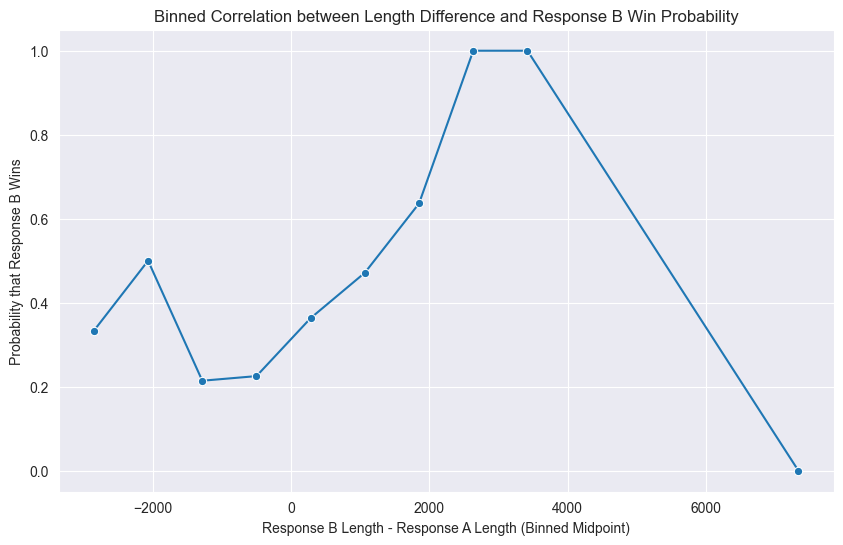

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create bins for the length difference
bins = np.linspace(train_df['length_diff'].min(), train_df['length_diff'].max(), 20)
train_df['length_diff_bin'] = pd.cut(train_df['length_diff'], bins)

# Calculate the probability (mean of winner_model_b) for each bin
binned_prob = train_df.groupby('length_diff_bin')['winner_model_b'].mean().reset_index()

# For plotting, take the midpoint of each bin for an x-axis value
binned_prob['bin_mid'] = binned_prob['length_diff_bin'].apply(lambda x: x.mid)

print(binned_prob.head())

plt.figure(figsize=(10, 6))
sns.lineplot(x='bin_mid', y='winner_model_b', data=binned_prob, marker="o")
plt.xlabel("Response B Length - Response A Length (Binned Midpoint)")
plt.ylabel("Probability that Response B Wins")
plt.title("Binned Correlation between Length Difference and Response B Win Probability")
plt.show()


Now, we want to explore the correlation between sentiment values and preference

In [6]:
import pandas as pd
import nltk
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    # Check if text is missing (NaN) or not a string, then convert it.
    if pd.isna(text):
        return 0.0  # or any default sentiment score, like 0 for neutral
    if not isinstance(text, str):
        text = str(text)
    scores = sia.polarity_scores(text)
    return scores['compound']

# Then apply this function to your cleaned response columns and prompt:
train_df['prompt_sentiment'] = train_df['clean_prompt'].apply(get_sentiment)
train_df['response_a_sentiment'] = train_df['clean_response_a'].apply(get_sentiment)
train_df['response_b_sentiment'] = train_df['clean_response_b'].apply(get_sentiment)

tdf['prompt_sentiment'] = tdf['clean_prompt'].apply(get_sentiment)
tdf['response_a_sentiment'] = tdf['clean_response_a'].apply(get_sentiment)
tdf['response_b_sentiment'] = tdf['clean_response_b'].apply(get_sentiment)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\cody_\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [19]:
train_df[['response_a_sentiment', 'response_b_sentiment']]


,response_a_sentiment,response_b_sentiment
0,0.9933,0.9200
1,0.9545,0.9529
2,0.2003,-0.2023
3,0.9868,0.9792
4,0.9702,0.8519
...,...,...
57472,0.7506,0.8689
57473,-0.2732,0.9632
57474,0.7980,-0.9789
57475,-0.7430,-0.8774


C:\Users\cody_\AppData\Local\Temp\ipykernel_4412\3637314671.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = train_df.groupby('sentiment_bin')['winner_model_b'].mean().reset_index()


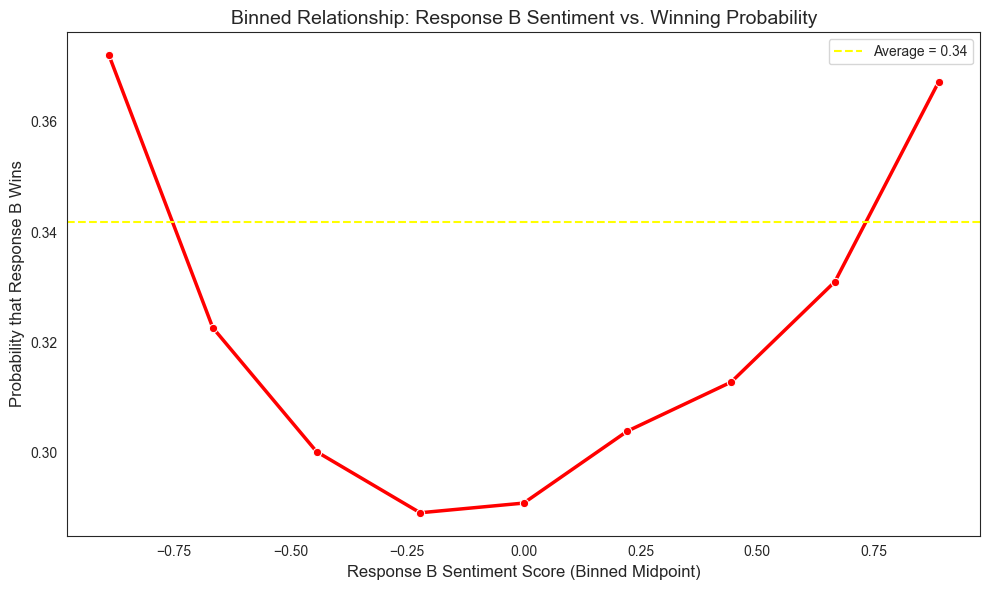

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

bins = np.linspace(train_df['response_b_sentiment'].min(), train_df['response_b_sentiment'].max(), 10)
train_df['sentiment_bin'] = pd.cut(train_df['response_b_sentiment'], bins)

binned_data = train_df.groupby('sentiment_bin')['winner_model_b'].mean().reset_index()
binned_data['bin_mid'] = binned_data['sentiment_bin'].apply(lambda x: x.mid)

overall_avg = train_df['winner_model_b'].mean()
sns.set_style("white")
plt.figure(figsize=(10, 6))
sns.lineplot(
    x='bin_mid',
    y='winner_model_b',
    data=binned_data,
    marker="o",
    color="red",
    linewidth=2.5
)
# Add horizontal dashed line for average
plt.axhline(y=overall_avg, color='yellow', linestyle='--', linewidth=1.5, label=f'Average = {overall_avg:.2f}')
plt.xlabel("Response B Sentiment Score (Binned Midpoint)", fontsize=12)
plt.ylabel("Probability that Response B Wins", fontsize=12)
plt.title("Binned Relationship: Response B Sentiment vs. Winning Probability", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()



Now, we want to add additional column for a parameter that numericalize word complexity
First, we need to refilter dataset such that we preserve stopwords and

In [12]:
!pip install textstat



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import textstat

def calculate_readability(text):
    # textstat.flesch_reading_ease returns a score
    # higher scores indicate material that is easier to read.
    try:
        # Ensure the text is a string.
        if not isinstance(text, str):
            text = str(text)
        # Calculate Flesch Reading Ease score.
        score = textstat.flesch_reading_ease(text)
        return score
    except Exception as e:
        print("Error processing text:", e)
        return None

train_df['response_a_readability'] = train_df['clean_response_a'].apply(calculate_readability)
train_df['response_b_readability'] = train_df['clean_response_b'].apply(calculate_readability)

tdf['response_a_readability'] = tdf['clean_response_a'].apply(calculate_readability)
tdf['response_b_readability'] = tdf['clean_response_b'].apply(calculate_readability)


In [23]:
train_df[['clean_response_a', 'response_a_readability']]

,clean_response_a,response_a_readability
0,the question of whether it is morally right to...,33.85
1,a marriage license is a legal document that al...,49.59
2,function calling is the process of invoking or...,61.56
3,creating a test set for a very rare category c...,35.20
4,the best way to travel from tel aviv to jerusa...,56.49
...,...,...
57472,"sure, let's break it down 1. how has 3 letters...",90.97
57473,here is an implementation of a naive bayes cla...,37.13
57474,working on weapons technology raises some ethi...,32.29
57475,bromadiolone is a rodenticide which is most of...,52.39


C:\Users\cody_\AppData\Local\Temp\ipykernel_4412\469202018.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['readability_bin'] = pd.cut(filtered_df['response_b_readability'], bins=bins)
C:\Users\cody_\AppData\Local\Temp\ipykernel_4412\469202018.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = filtered_df.groupby('readability_bin').agg(


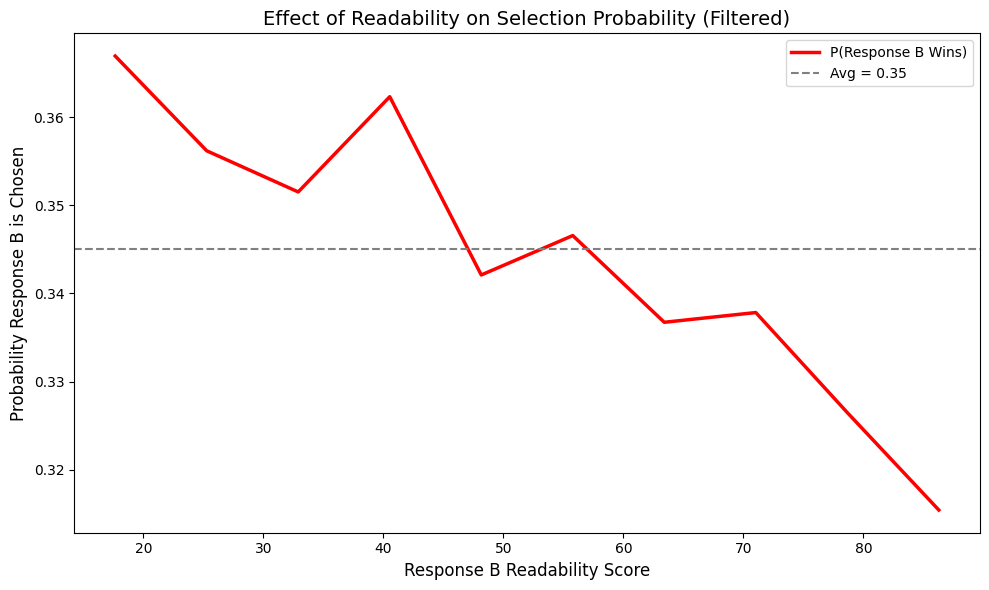

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the percentiles for outlier removal
lower_bound = train_df["response_b_readability"].quantile(0.05)
upper_bound = train_df["response_b_readability"].quantile(0.95)

# Filter the DataFrame
filtered_df = train_df[
    (train_df["response_b_readability"] >= lower_bound) &
    (train_df["response_b_readability"] <= upper_bound)
]

# Bin the readability scores
num_bins = 10
bins = np.linspace(filtered_df['response_b_readability'].min(),
                   filtered_df['response_b_readability'].max(),
                   num_bins + 1)
filtered_df['readability_bin'] = pd.cut(filtered_df['response_b_readability'], bins=bins)

bin_summary = filtered_df.groupby('readability_bin').agg(
    probability=('winner_model_b', 'mean')
).reset_index()

# Midpoints for plotting
bin_midpoints = bins[:-1] + np.diff(bins) / 2
bin_summary['bin_midpoint'] = bin_midpoints

overall_avg = filtered_df['winner_model_b'].mean()

# Plot
plt.style.use('default')  # White background
plt.figure(figsize=(10, 6))

# Red line, no markers or error bars
plt.plot(
    bin_summary['bin_midpoint'],
    bin_summary['probability'],
    color='red',
    linewidth=2.5,
    label='P(Response B Wins)'
)

# Add average horizontal line
plt.axhline(y=overall_avg, color='yellow', linestyle='--', linewidth=1.5, label=f'Avg = {overall_avg:.2f}')

# Axis labels and title
plt.xlabel('Response B Readability Score', fontsize=12)
plt.ylabel('Probability Response B is Chosen', fontsize=12)
plt.title('Effect of Readability on Selection Probability (Filtered)', fontsize=14)

# Grid and legend
plt.legend()
plt.tight_layout()
plt.show()





C:\Users\cody_\AppData\Local\Temp\ipykernel_4412\2707444721.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_diff_df['readability_diff_bin'] = pd.cut(filtered_diff_df['readability_diff'], bins=bins_diff)
C:\Users\cody_\AppData\Local\Temp\ipykernel_4412\2707444721.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary_diff = filtered_diff_df.groupby('readability_diff_bin').agg(


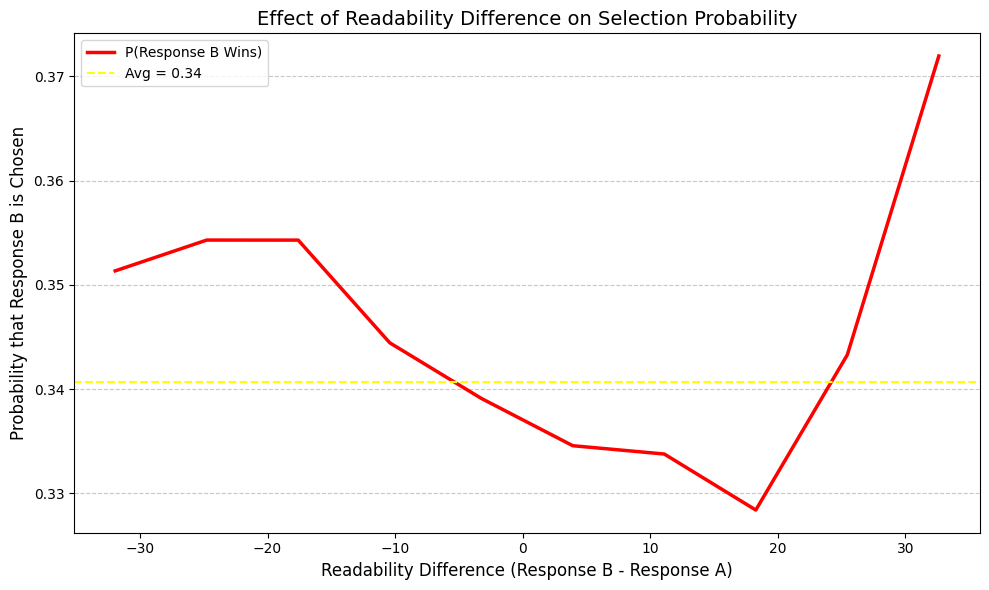

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Compute readability difference
train_df['readability_diff'] = train_df['response_b_readability'] - train_df['response_a_readability']
tdf['readability_diff'] = tdf['response_b_readability'] - tdf['response_a_readability']

# Remove outliers
lower_bound_diff = train_df['readability_diff'].quantile(0.05)
upper_bound_diff = train_df['readability_diff'].quantile(0.95)
filtered_diff_df = train_df[
    (train_df['readability_diff'] >= lower_bound_diff) &
    (train_df['readability_diff'] <= upper_bound_diff)
]

# Bin the data
num_bins = 10
bins_diff = np.linspace(filtered_diff_df['readability_diff'].min(),
                        filtered_diff_df['readability_diff'].max(),
                        num_bins + 1)
filtered_diff_df['readability_diff_bin'] = pd.cut(filtered_diff_df['readability_diff'], bins=bins_diff)

bin_summary_diff = filtered_diff_df.groupby('readability_diff_bin').agg(
    probability=('winner_model_b', 'mean')
).reset_index()

# Compute midpoints
bin_midpoints_diff = bins_diff[:-1] + np.diff(bins_diff) / 2
bin_summary_diff['bin_midpoint'] = bin_midpoints_diff

# Compute overall average
overall_avg = filtered_diff_df['winner_model_b'].mean()

plt.style.use('default')  # White background
plt.figure(figsize=(10, 6))
plt.plot(
    bin_summary_diff['bin_midpoint'],
    bin_summary_diff['probability'],
    color='red',
    linewidth=2.5,
    label='P(Response B Wins)'
)
# Horizontal average line
plt.axhline(y=overall_avg, color='yellow', linestyle='--', linewidth=1.5, label=f'Avg = {overall_avg:.2f}')
plt.xlabel('Readability Difference (Response B - Response A)', fontsize=12)
plt.ylabel('Probability that Response B is Chosen', fontsize=12)
plt.title('Effect of Readability Difference on Selection Probability', fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\cody_\AppData\Local\Temp\ipykernel_4412\3894020553.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_diff_df['readability_diff_bin'] = pd.cut(filtered_diff_df['readability_diff'], bins=bins_diff)
C:\Users\cody_\AppData\Local\Temp\ipykernel_4412\3894020553.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary_diff = filtered_diff_df.groupby('readability_diff_bin').agg(


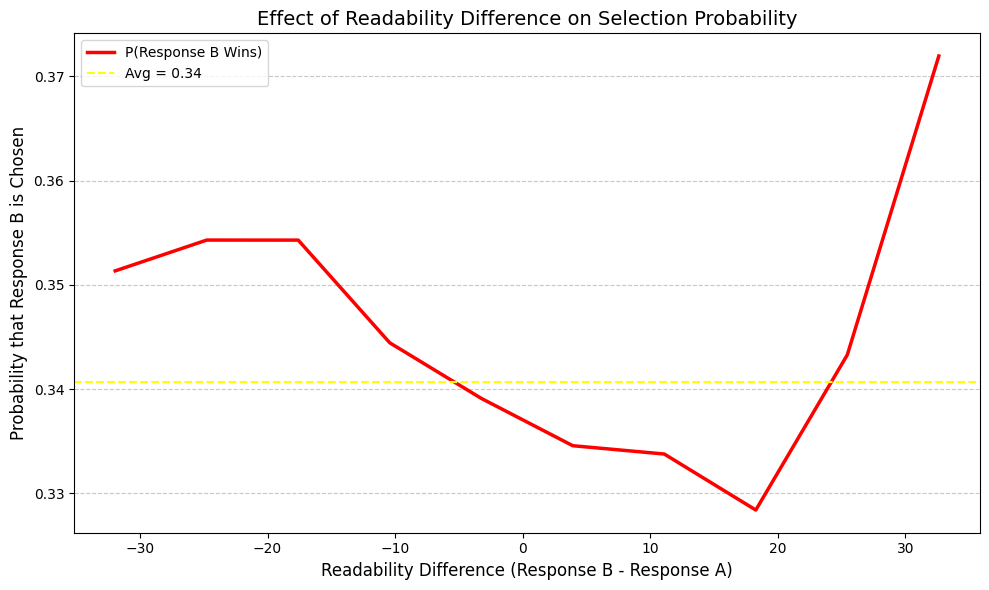

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Compute readability difference
train_df['readability_diff'] = train_df['response_b_readability'] - train_df['response_a_readability']
tdf['readability_diff'] = tdf['response_b_readability'] - tdf['response_a_readability']

# Remove outliers
lower_bound_diff = train_df['readability_diff'].quantile(0.05)
upper_bound_diff = train_df['readability_diff'].quantile(0.95)
filtered_diff_df = train_df[
    (train_df['readability_diff'] >= lower_bound_diff) &
    (train_df['readability_diff'] <= upper_bound_diff)
]

# Bin the data
num_bins = 10
bins_diff = np.linspace(filtered_diff_df['readability_diff'].min(),
                        filtered_diff_df['readability_diff'].max(),
                        num_bins + 1)
filtered_diff_df['readability_diff_bin'] = pd.cut(filtered_diff_df['readability_diff'], bins=bins_diff)

# Group and aggregate
bin_summary_diff = filtered_diff_df.groupby('readability_diff_bin').agg(
    probability=('winner_model_b', 'mean')
).reset_index()

# Compute midpoints
bin_midpoints_diff = bins_diff[:-1] + np.diff(bins_diff) / 2
bin_summary_diff['bin_midpoint'] = bin_midpoints_diff

# Compute overall average
overall_avg = filtered_diff_df['winner_model_b'].mean()

# Plot
plt.style.use('default')  # White background
plt.figure(figsize=(10, 6))

# Red smooth line (no markers or error bars)
plt.plot(
    bin_summary_diff['bin_midpoint'],
    bin_summary_diff['probability'],
    color='red',
    linewidth=2.5,
    label='P(Response B Wins)'
)

# Horizontal average line
plt.axhline(y=overall_avg, color='yellow', linestyle='--', linewidth=1.5, label=f'Avg = {overall_avg:.2f}')

# Labels and formatting
plt.xlabel('Readability Difference (Response B - Response A)', fontsize=12)
plt.ylabel('Probability that Response B is Chosen', fontsize=12)
plt.title('Effect of Readability Difference on Selection Probability', fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()




C:\Users\cody_\AppData\Local\Temp\ipykernel_4412\964347525.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_a['readability_a_bin'] = pd.cut(filtered_df_a['response_a_readability'], bins=bins_a)
C:\Users\cody_\AppData\Local\Temp\ipykernel_4412\964347525.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary_a = filtered_df_a.groupby('readability_a_bin').agg(


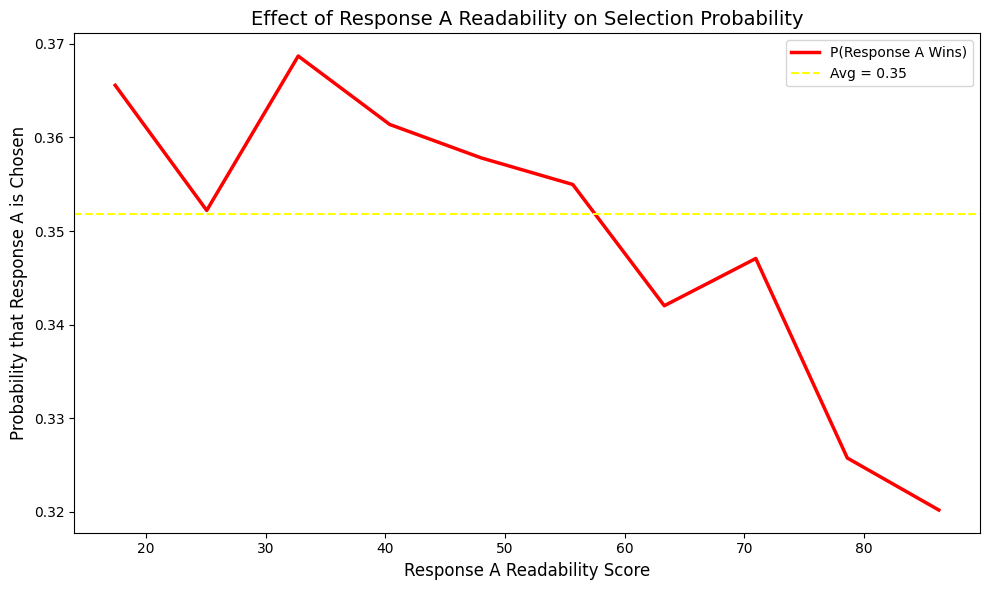

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Filter out extreme outliers for response_a_readability
lower_bound_a = train_df["response_a_readability"].quantile(0.05)
upper_bound_a = train_df["response_a_readability"].quantile(0.95)

filtered_df_a = train_df[
    (train_df["response_a_readability"] >= lower_bound_a) &
    (train_df["response_a_readability"] <= upper_bound_a)
]

# Bin the data
num_bins = 10
bins_a = np.linspace(filtered_df_a['response_a_readability'].min(),
                     filtered_df_a['response_a_readability'].max(),
                     num_bins + 1)

filtered_df_a['readability_a_bin'] = pd.cut(filtered_df_a['response_a_readability'], bins=bins_a)

bin_summary_a = filtered_df_a.groupby('readability_a_bin').agg(
    probability=('winner_model_a', 'mean')
).reset_index()

# Midpoints for bins
bin_midpoints_a = bins_a[:-1] + np.diff(bins_a) / 2
bin_summary_a['bin_midpoint'] = bin_midpoints_a

# Compute overall average
overall_avg = filtered_df_a['winner_model_a'].mean()

plt.style.use('default')  # White background
plt.figure(figsize=(10, 6))
plt.plot(
    bin_summary_a['bin_midpoint'],
    bin_summary_a['probability'],
    color='red',
    linewidth=2.5,
    label='P(Response A Wins)'
)

# Horizontal average line
plt.axhline(y=overall_avg, color='yellow', linestyle='--', linewidth=1.5, label=f'Avg = {overall_avg:.2f}')
plt.xlabel('Response A Readability Score', fontsize=12)
plt.ylabel('Probability that Response A is Chosen', fontsize=12)
plt.title('Effect of Response A Readability on Selection Probability', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()



In [27]:
train_df.to_csv('../data/processed_data.csv', index=False)
tdf.to_csv('../data/processed_test.csv', index=False)